In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import timeit

# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


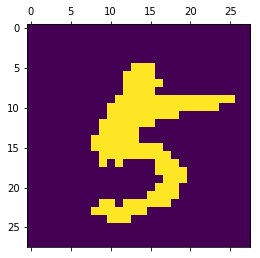

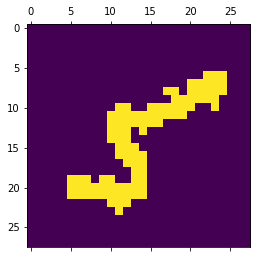

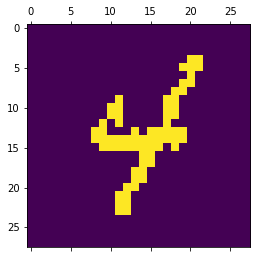

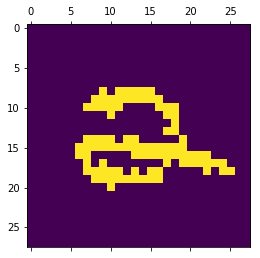

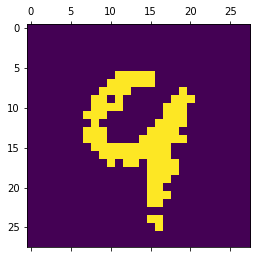

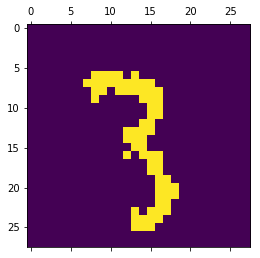

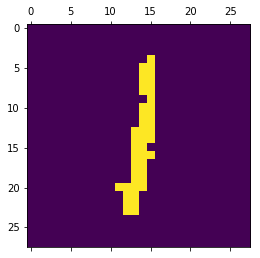

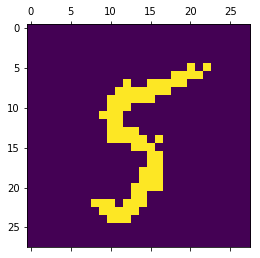

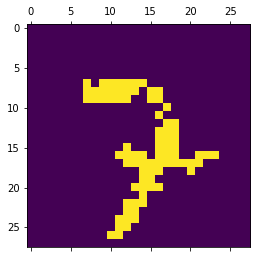

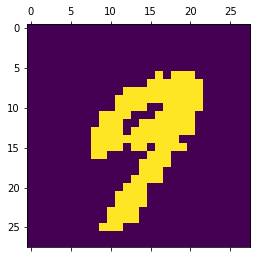

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())

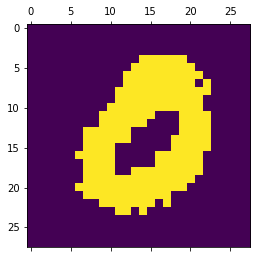

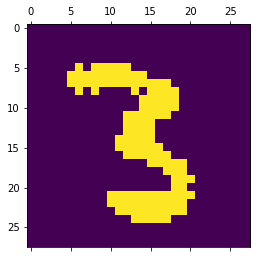

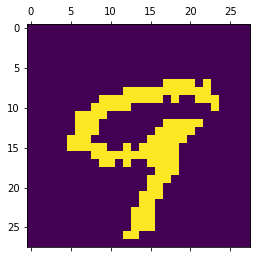

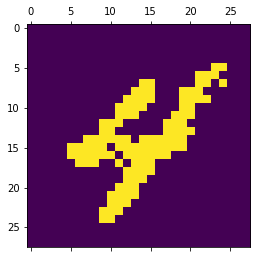

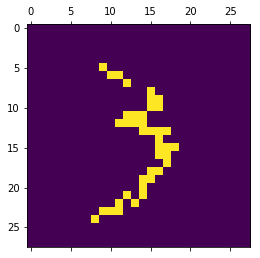

In [5]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())

In [6]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [7]:
batchsize = 8

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [8]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [9]:
data_unlabeled['image'].shape

torch.Size([8, 28, 28])

# Define VAE

In [10]:
latent_dim = 5
n_classes = 10

In [11]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [12]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [13]:
28 * 28

784

In [14]:
2 * 28 * 28

1568

In [15]:
### Check things run

In [16]:
num_unlabled = train_loader_unlabeled.sampler.data_source.num_images

In [17]:
vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, reinforce = True)

(tensor(32532.4941), tensor(1.00000e+05 *
        -2.9031), tensor(541.7180), tensor(544.3250), tensor(2.2952))

# Check gradient works 

In [18]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [19]:
vae_params0 = get_vae_params(vae)

In [20]:
assert np.any(np.isnan(vae_params0)) == False

In [21]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [22]:
loss, ps_loss, _, _, _ = vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, reinforce = True)

In [23]:
loss.backward()
optimizer.step()

In [24]:
vae_params1 = get_vae_params(vae)

In [25]:
assert np.any(np.isnan(vae_params1)) == False

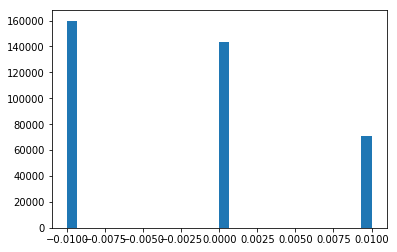

In [26]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [27]:
loss, ps_loss, _, _, _ = vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, reinforce = True)

In [28]:
assert np.isfinite(loss.detach().numpy())

In [29]:
train_loader_unlabeled.dataset.__len__()

54

In [30]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, data_labeled['image'], data_labeled['label'], 
                    test_loader, n_epoch = 5, print_every = 2, outfile = './test', reinforce = True)

  * init train recon loss: 509.3335876;
  * init test recon loss: 510.0029907;
  * init train class accuracy: 0.1111;
  * init test class accuracy:  0.1;
[1] unlabeled_loss: 466.820343  	[0.5 seconds]
[2] unlabeled_loss: 375.9850464  	[0.5 seconds]
  * train recon loss: 293.335968;
  * test recon loss: 312.7670593;
  * train class accuracy: 0.09259;
  * test class accuracy:  0.1;
[3] unlabeled_loss: 261.2276306  	[0.5 seconds]
[4] unlabeled_loss: 223.4215851  	[0.5 seconds]
  * train recon loss: 213.6532135;
  * test recon loss: 228.5049438;
  * train class accuracy: 0.09259;
  * test class accuracy:  0.1;
[5] unlabeled_loss: 212.866333  	[0.5 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [31]:
image = data_unlabeled['image']

In [32]:
class_weights = vae.classifier(image)

In [33]:
from torch.distributions import Normal, Categorical

In [34]:
# probs = torch.Tensor([[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
probs = class_weights

In [35]:
cat_rv = Categorical(probs = probs)

In [36]:
z_sample = cat_rv.sample().detach()

In [37]:
z_sample

tensor([ 8,  8,  7,  5,  5,  3,  8,  3])

In [43]:
z = 8

In [44]:
mask = np.zeros(len(z_sample))
mask[z_sample.cpu().numpy() == z] = 1

In [45]:
mask

array([1., 1., 0., 0., 0., 0., 1., 0.])

In [46]:
vae.get_conditional_loss(image, 4)

tensor([ 291.7997,  220.9380,  208.5308,  162.0827,  239.0970,  187.5836,
         198.2960,  204.2743])

In [47]:
class_weights.shape

torch.Size([8, 10])